# Rendu projet Neo4J

## Introduction
Ce travail a été réalisé par Baptiste Chezaubernard, Alix Ouedraogo et Alexis Aubrée.

Nous avons choisi de rendre un notebook, car ce format nous permet de mélanger la documentation du travail réalisé avec du code et de la visualisation.
Les requêtes sont présentes dans ce rapport et peuvent être utilisées indépendamment de ce support

Ci dessous, nous importons l'ensemble des librairies et fonctions nécessaires au bon fonctionnement de ce notebook.

Avant de lancer ce notebook, il faut executer la commande ```pip install -r requirements.txt```

In [1]:
%run python/utils.py

Imports réalisés


### Contexte
Ce projet a pour but d'utiliser Neo4j pour étudier des graphes.
Nous avons choisi d'utiliser les données de [spotify](https://zenodo.org/record/2594557#.XeYt25NKhqO).

Ces données représentent les interractions entre les utilisateurs, les chansons, les playlists et les artistes. Les chansons et artistes sont majoritairement du genre rock.

Une partie des données est présentées ci-dessous.

In [2]:
readHead("data/base.csv")

,user_id,artist_name,track_name,playlist_name
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010


Nous avons enrichi ces données à l'aide de l'API de spotify. Nous avons rajouté pour chaque artiste les artistes liés, la popularité, leurs genres musicaux.

Un extrait du fichier obtenu est présenté ci-dessous.

In [3]:
readHead("data/artists.csv")

,artist_name,artist_id,genres,popularity,related
0,Elvis Costello,2BGRfQgtzikz1pzAD0kaEn,"['art rock', 'dance rock', 'folk', 'folk rock'...",60.0,"['Elvis Costello & The Attractions', 'Squeeze'..."
1,Elvis Costello & The Attractions,4qmHkMxr6pTWh5Zo74odpH,"['art rock', 'comic', 'dance rock', 'folk rock...",59.0,"['Elvis Costello', 'Squeeze', 'Joe Jackson', '..."
2,Tiffany Page,1Q6EgKHZ8mt7Hm5bKa6DbG,[],4.0,"['Heidi Range', 'Alex Roots', 'Hepburn', 'Heav..."


Enfin, nous avons complété nos données à l'aide des données des concerts pour les artistes. Ces données ont été obtenue à l'aide du site [concertarchive](https://www.concertarchives.org/).

Une partie de ces données est présentée ci-dessous

In [4]:
readHead("data/concerts.csv", delimiter="|")

,id,artist,date,nom_concert,endroit,ville
0,0,Elvis Costello,"Mar 08, 2014",Elvis Costello / Elvis Costello & The Imposters,Caesar's Atlantic City,"Atlantic City, NJ"
1,1,Elvis Costello,"Jul 06, 2003",Elvis Costello & The Imposters / Imposters / E...,Taste of Chicago,"Chicago, IL"
2,2,Elvis Costello,"Nov 10, 2019",Elvis Costello & The Imposters / Elvis Costell...,The Mahaffey Theater,"St Petersburg, FL"


Au final, nous obtenons le schéma ci-dessous

![](./images/NeoModel.png)

## 1. Imports des données

### Connexion à la base de données

Les informations de connexion à la base de données peuvent être changées au besoin.

In [5]:
DB_URI = "bolt://localhost:7687"
DB_USER = "neo4j"
DB_PASSWORD = "password"
driver = GraphDatabase.driver(DB_URI, auth=(DB_USER, DB_PASSWORD))

### Définition de la structure de la base

Nous créons des contraintes sur tous les objets, sauf sur concert, tous les attributs sont importants pour les concerts

In [6]:
CONSTRAINTS=[
    # On vérifie que l'ID utilisateur est unique
    "CREATE CONSTRAINT ON (u:User) ASSERT u.id IS UNIQUE;",
    # On vérifie que le nom du son est unique
    "CREATE CONSTRAINT ON (s:Song) ASSERT s.track_name IS UNIQUE;",
    # On vérifie que le nom de l'artiste est unique
    "CREATE CONSTRAINT ON (a:Artist) ASSERT a.artist_name IS UNIQUE;", 
    # On vérifie que le nom de la playlist est unique
    "CREATE CONSTRAINT ON (p:Playlist) ASSERT p.playlist_name IS UNIQUE; ",
    # On vérifie que le nom du genre est unique
    "CREATE CONSTRAINT ON (g:Genre) ASSERT g.genre_name IS UNIQUE;",
    # On vérifie qu'il n'y a pas 2 concerts qui portent le même nom le même jour
    "CREATE CONSTRAINT ON (c:Concert) ASSERT (c.date, c.nom_concert) IS NODE KEY",
    # On vérifie que le nom de la ville est unique
    "CREATE CONSTRAINT ON (v:Ville) ASSERT v.ville_name IS UNIQUE;"
]
with driver.session() as session:
    for constraint in CONSTRAINTS:
        session.run(constraint)

### Import des données

⚠️⚠️⚠️ 

Les 4 fichiers CSV base, artists, concerts et villes doivent être copiées dans le répértoire 'import' de la base de données Neo4j 

⚠️⚠️⚠️

Import de la base (Temps de traitement long ~8 minutes)

In [8]:
REQUETE = """
// Import file base.csv
USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///base.csv'
 	AS ligne FIELDTERMINATOR ';'

    // If there is a track name
    FOREACH(ignoreMe IN CASE WHEN ligne.track_name <> '' THEN [1] ELSE [] END |
        MERGE (u:User {id: ligne.user_id})
        MERGE (s:Song {track_name: ligne.track_name})
        MERGE (a:Artist {artist_name: ligne.artist_name})
        // If there is a playlist name
        FOREACH(ignoreMe IN CASE WHEN ligne.playlist_name <> '' THEN [1] ELSE [] END |
            MERGE (p:Playlist {playlist_name: ligne.playlist_name})
            MERGE (p)-[:CONTAINS]->(s)
        )
        MERGE (u)-[:LISTEN_TO]->(s)
        MERGE (a)-[:PLAYS]->(s)
    )

"""
with driver.session() as session:
    session.run(REQUETE)

Import des artistes ~1 minutes

In [9]:
REQUETE = """
// Import file artists.csv
USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///artists.csv'
 	AS ligne FIELDTERMINATOR ';'
    
    MERGE (a:Artist {artist_name: ligne.artist_name})
    SET a.id = ligne.artist_id
    SET a.popularity = ligne.popularity
    FOREACH(genre IN split(ligne.genres, "', '") |
        // In order to remove the [' & '] before the lines
        MERGE(g:Genre {
            genre_name: replace(
                replace(genre, "['", "")
            , "']", "")
            })
        MERGE (a)-[:PLAYS_GENRE]->(g)
    )
    FOREACH(relatedArtist IN split(ligne.related, "', '") |
        // In order to remove the [' & '] before the lines
        MERGE(rA:Artist {
            artist_name: replace(
                replace(relatedArtist, "['", "")
            , "']", "")
            })
        MERGE (a)-[:IS_RELATED_TO]->(rA)
    )

"""
with driver.session() as session:
    session.run(REQUETE)

Import des concerts ~2 minutes

In [10]:
REQUETE = """
// Import file concerts.csv
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS FROM 'file:///concerts.csv'
 	AS ligne FIELDTERMINATOR '|'
    
    MERGE (a:Artist {artist_name: ligne.artist})

    MERGE (c:Concert {
        date: ligne.date,
        nom_concert: ligne.nom_concert
        })
    SET c.salle_concert= ligne.endroit
    MERGE(v:Ville {ville_name: ligne.ville})
    MERGE (a)-[:PLAYS_IN]->(c)
    MERGE (c)-[:IS_IN]->(v)
"""
with driver.session() as session:
    session.run(REQUETE)

On importe ensuite les informations des villes. Ces informations ont été récupérées à l'aide de l'API google maps

In [14]:
REQUETE = """
// Import file villes.csv
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS FROM 'file:///villes.csv'
 	AS ligne FIELDTERMINATOR '|'
    FOREACH(ignoreMe IN CASE WHEN ligne.ville <> '' THEN [1] ELSE [] END |

        MERGE (v:Ville {ville_name: ligne.ville})
        SET v.lat = ligne.lat
        SET v.lng = ligne.lng
    )
"""
with driver.session() as session:
    session.run(REQUETE)

## 2. Requetes
### 2.1 - PageRank

⚠️⚠️⚠️ Nécessite d'avoir installé le plugin [GRAPH ALGORITHMS](https://neo4j.com/developer/graph-algorithms/) ⚠️⚠️⚠️
Ce plugin peut être installé depuis neo4jDesktop

La requête ci-dessous calcule le page rang pour chaque artiste

In [13]:
REQUETE = """
CALL algo.pageRank.stream('Artist', 'IS_RELATED_TO', {iterations:40, dampingFactor:0.85})
YIELD nodeId, score

RETURN algo.asNode(nodeId).artist_name AS Artist,score
ORDER BY score DESC
LIMIT 10
"""
print("{0:40} {1:30}".format("Artiste","Score"))
with driver.session() as session:
    for record in session.run(REQUETE):
        print("{0:30} {1:30}".format(record['Artist'],record['score']))

Artiste                                  Score                         
Michael Kamen                               5.013795362471136
John Ottman                                 4.996194266970271
[]                                         4.6904644961235595
Harald Kloser                               4.497847101109803
The Pigeon Detectives                        4.40809383730375
Marco Beltrami                              4.282494479586604
The Rifles                                  3.991114863933762
Randy Edelman                              3.7172479606233533
Submersed                                  3.6457826531841415
Ilan Eshkeri                               3.5777379637584086


On remarque que les artistes les plus liés aux autres artistes sont Michael Kamen et John Ottman.
L'artiste "\[\]" indique les artistes qui ne pointent sur aucun autre artiste.

On remarque également que le pageRank n'est pas une mesure efficace de la popularité d'un artiste. Après étude, nous avons remarqué que les graphes représentants les artistes liés sont cycliques, avec un nombre faibles de noeuds (~30). Seule la taille du cycle compte pour le pageRank.

Le pageRank étant une information importante, on décide de la sauvegarder dans le champ artiste. Pour ce faire, on execute la requete ci-dessous.

In [44]:
REQUETE = """
CALL algo.pageRank('Artist', 'IS_RELATED_TO',
  {iterations:40, dampingFactor:0.85, write: true,writeProperty:"pagerank"})
YIELD nodes, iterations, loadMillis, computeMillis, writeMillis, dampingFactor, write, writeProperty
"""
with driver.session() as session:
    for record in session.run(REQUETE):
         print(record)

<Record nodes=13715 iterations=40 loadMillis=53 computeMillis=52 writeMillis=6 dampingFactor=0.85 write=True writeProperty='pagerank'>


### 2.2 Les playlists les plus écoutées
On récupère les 10 playlist les plus écoutées.
Le traitement un peu long (~30 secondes)

Starred                                                700911
Liked from Radio                                       348844
Favoritas de la radio                                  186597
Everything at once                                     145865
Rock                                                   142998
Spotify Library                                        105257
Rich's iPhone                                           97709
All Live Files                                          95662
dicos varios                                            94305
Indie                                                   83164


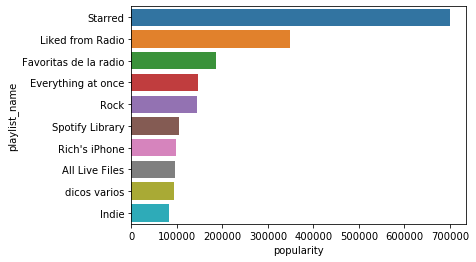

In [105]:
REQUETE = """
// The 30 most listened playlist with the number of plays
MATCH(u:User)-[:LISTEN_TO]->(s:Song)<-[:CONTAINS]-(p:Playlist)
WITH p, count(u) AS popularity
RETURN p.playlist_name AS playlist_name, popularity
ORDER BY popularity DESC
LIMIT 10
"""
data=[]
with driver.session() as session:
    for record in session.run(REQUETE):
        print("{0:30} {1:30}".format(record['playlist_name'],record['popularity']))
        data.append([record['playlist_name'], record['popularity']])
# Un peu de visualisation
df = pd.DataFrame.from_records(data, columns=["playlist_name", "popularity"])
fig = sns.barplot(x = 'popularity', y = 'playlist_name', 
                  data = df,)

### 2.3 Les genres les plus écoutés
On récupère le nombre d'écoute de chaque genre et on l'enregistre au sein du noeud.

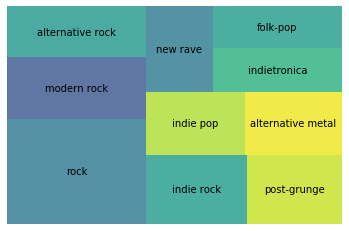

In [109]:
REQUETE = """
// The 30 most listened playlist with the number of plays
MATCH(u:User)-[:LISTEN_TO]->(s:Song)<-[:PLAYS]-(a:Artist)-[:PLAYS_GENRE]->(g:Genre)
WITH g, count(u) AS popularity
SET g.popularity=popularity
RETURN g.genre_name as genre_name, popularity
ORDER BY popularity DESC
LIMIT 10
"""
data=[]
with driver.session() as session:
    for record in session.run(REQUETE):
        data.append([record['genre_name'], record['popularity']])
# Un peu de visualisation
df = pd.DataFrame.from_records(data, columns=["genre_name", "popularity"])
squarify.plot(sizes=df['popularity'], label=df['genre_name'], alpha=.8 )
plt.axis('off')
plt.show()

### La localisation géographique des concerts d'un utilisateur

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))